In [1]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt
import copy 

from growingline import *

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 

ogr.UseExceptions()

In [2]:
ds = None 


In [3]:
layer_name = "abseits"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp_ohne.gpkg"))

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['TEMPLINELAYER', 'abseits', 'anfang weiche', 'kurve', 'viele', 'viele1', 'weiche']


In [4]:
# Add a temporary "skip" field if it doesn't exist
if layer.FindFieldIndex("skip", 1) == -1:
    field = ogr.FieldDefn("skip", ogr.OFTInteger)
    layer.CreateField(field)

In [5]:
def new_line_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "centerlines"):
        delete_layer(ds, "centerlines", logger)
    layer = ds.CreateLayer("centerlines", spatial_reference, ogr.wkbLineString25D)
    return layer 

def new_switch_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "switch"):
        delete_layer(ds, "switch", logger)
    layer = ds.CreateLayer("switch", spatial_reference, ogr.wkbPoint)
    return layer


linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)
switchlayer = new_switch_layer(ds, layer.GetSpatialRef(), None)


In [6]:
def get_all_points(layer):
    """Get all points from the layer as a list of numpy arrays"""
    points = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        for i in range(geom.GetPointCount()):
            point = np.array(geom.GetPoint(i)[:3])
            points.append(point)

    layer.ResetReading()
    return np.array(points)

In [7]:
queue = deque()

In [8]:
all_points = get_all_points(layer)

In [9]:

layer.GetFeatureCount()

12620

## Start

In [3731]:
layer.ResetReading()

In [3732]:
layer.SetAttributeFilter("skip IS NULL")

feature = layer.GetNextFeature()

layer.ResetReading()
layer.SetAttributeFilter(None)

feature


OGRFeature(abseits):22909
  eig x (Real) = 0.218478425179816
  eig y (Real) = -0.975728943029262
  eig z (Real) = 0.014839389001824
  gauge (Real) = 1.43596350494589
  min points (Integer) = 415
  skip (Integer) = (null)
  POINT Z (4473649.32716209 5338094.67181769 515.754066444995)


In [3733]:
# feature = layer.GetFeature(271571) 
# feature  

In [3734]:
active_line = GrowingLine.from_feature(feature)


In [3735]:
first_iteration = True

## Ab hier muss dann Schleife

In [5159]:
print("Current starting point:", feature.GetFID())
xyz, directions, fids, switches = active_line.points_in_direction(layer, switchlayer)
new_switches = []
print(len(xyz), "Points in direction")
if len(switches) > 0:
    print("Switches found:", len(switches))

if len(xyz) < 3:
    remove_points(fids, layer)
    if active_line.in_switch:
        geom = ogr.Geometry(ogr.wkbPoint)
        geom.AddPoint_2D(active_line.head_xyz[0], active_line.head_xyz[1])
        new_switches.append(np.array(active_line.head_xyz))
        add_to_layer(switchlayer, geom)

    not_finished = active_line.reverse_head()
    if not_finished is False:
        queue.extend(active_line.next_lines)
        print(len(queue), "in queue")
        if len(queue) == 0:
            print("START FROM START")
        active_line = queue.popleft()

Current starting point: 22909
7 Points in direction
Switches found: 1


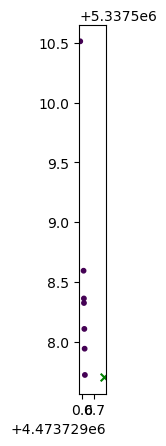

In [5160]:
labels = ransac_lines(xyz, threshold=0.06, max_iterations=20)
max_label = labels.max()

x = xyz[:, 0]
y = xyz[:, 1]
fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')

for point in switches:
    ax.scatter(point[0], point[1], c='green', marker='x', s=30)

In [5161]:
len(labels[labels == -1])

0

In [5162]:
labels[0], labels.max()

(np.int64(0), np.int64(0))

In [5163]:
if (active_line.start_fid is not None): print("active line is reversable")

active line is reversable


In [5164]:
backup = copy.deepcopy(active_line)

In [5165]:
# If the start point is in a switch, it causes all kinds of problems 
if first_iteration and max_label > 0:
    # Create another line and stop here
    feature.SetField("skip", 1)
    layer.SetFeature(feature)

    print("old", feature.GetFID())

    layer.ResetReading()
    layer.SetAttributeFilter("skip IS NULL")
    feature = layer.GetNextFeature()
    layer.ResetReading()
    layer.SetAttributeFilter(None)
    print("new", feature.GetFID())
    active_line = GrowingLine.from_feature(feature)
    first_iteration = True
    raise StartInSwitchError
first_iteration = False

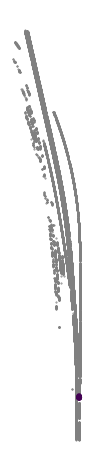

In [5166]:
fig, ax = plt.subplots()
ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=0.2)
ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
fig.tight_layout()
fig.savefig("current_ransac_lines.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [5167]:
fids 

array([227116, 227104, 227078, 227068, 227241, 227127, 227065])

In [5168]:
remove_points(fids[labels == -1], layer)

In [5169]:
print("Letzte Punkte:", np.array(active_line.points)[-5:])

Letzte Punkte: [[4.47372952e+06 5.33751454e+06 5.13056099e+02]
 [4.47372953e+06 5.33751370e+06 5.13061774e+02]
 [4.47372955e+06 5.33751287e+06 5.13068187e+02]
 [4.47372957e+06 5.33751131e+06 5.13080534e+02]
 [4.47372958e+06 5.33751051e+06 5.13086309e+02]]


In [ ]:
# Check if we reached the end of a switch
if active_line.in_switch() and labels.max() == 0:
    if labels[0] == -1:
        print("Active line ends in switch")
        # idx = active_line.index_closest_point([active_line.switch[0], active_line.switch[1]])
        # closest_point = active_line.points[idx]
        geom = ogr.Geometry(ogr.wkbPoint)
        geom.AddPoint_2D(active_line.head_xyz[0], active_line.head_xyz[1]) 
        add_to_layer(switchlayer, geom)

        new_switches.append(active_line.head_xyz)
        make_cut = True # Reverses head
    else:
        length = np.linalg.norm(active_line.switch[0] - active_line.switch[-1])
        print("Switch line length:", length)
        if length > 3:
            make_cut = True
            print("CUT")
            print("switch", active_line.switch)

            point = active_line.make_cut()
            geom = ogr.Geometry(ogr.wkbPoint)
            geom.AddPoint_2D(point[0], point[1])
            add_to_layer(switchlayer, geom)
            new_switches.append(point)
        else:
            make_cut = False
            print("No cut, switch line too short")
            active_line.switch = None

else:
    make_cut = False
    for label in range(labels.max()+1):
        cluster = xyz[labels == label]
        if len(cluster) < 2:
            continue

        
        fids_cluster = fids[labels == label]
        directions_cluster = directions[labels == label]
        

        if label == labels[0]:
            # This is the active head 
            pruned, offset = pruned_points(cluster)
            remove_points(fids_cluster[:offset+1], layer)

            new_direction = directions_cluster[offset]
            if active_line.head_direction @ new_direction < 0:
                new_direction = -new_direction

            active_line.head_xyz = pruned[-1]
            active_line.head_direction = new_direction
            active_line.head_fid = fids_cluster[offset]

            if np.array_equal(pruned[0], active_line.points[-1]):
                # Remove the first point if it is already in the line
                pruned = pruned[1:]  
            
            active_line.points.extend(pruned) 
            print(len(pruned), "points added to active line")
        else:
            # This is the other rail in a switch (or false positive)
            active_line.add_switchline(cluster)
            active_line.unpruned.extend(xyz[labels == labels[0]])

    if len(switches) > 0 and not first_iteration:
        # Add the last point if it is not there 
        cluster = xyz[labels == labels[0]]
        if not np.array_equal(cluster[-1], active_line.head_xyz):
            active_line.points.append(cluster[-1])
        active_line.make_cut(switches)
        make_cut = True



1 points added to active line
Letzte Punkte: [[4.47372953e+06 5.33751370e+06 5.13061774e+02]
 [4.47372955e+06 5.33751287e+06 5.13068187e+02]
 [4.47372957e+06 5.33751131e+06 5.13080534e+02]
 [4.47372958e+06 5.33751051e+06 5.13086309e+02]
 [4.47372961e+06 5.33750859e+06 5.13099268e+02]]
index unpruned False
indices [np.int64(665)]
distances [np.float64(0.9074191772675709)]
666 points
Cut index: 665 of 666 points


In [ ]:
pruned  

[array([4.47372961e+06, 5.33750859e+06, 5.13099268e+02])]

In [5171]:
print("active line points:", len(active_line.points))
print("in switch:", active_line.in_switch())

active line points: 666
in switch: False


In [5172]:
if active_line.switch:
    print("Switch points:", len(active_line.switch))
    print("distance" , np.linalg.norm(active_line.switch[0] - active_line.switch[-1]))

In [5173]:
len(active_line.unpruned)

0

(5337477.355651687, 5338125.020206545)

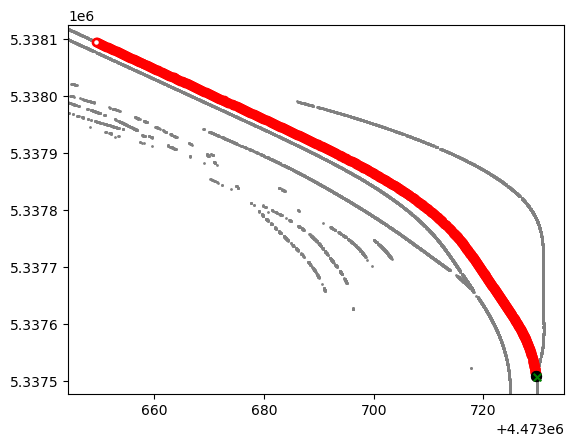

In [5174]:
fig, ax = plt.subplots()


active = np.array(active_line.points) 

ax.scatter(active[:, 0], active[:, 1], c='red')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')

if active_line.switch is not None:
    for point in active_line.switch:
        ax.scatter(point[0], point[1], c='blue', s=50)
   
for point in switches:
    ax.scatter(point[0], point[1], c='green', marker='x', s=30)

for point in new_switches:
    ax.scatter(point[0], point[1], c='orange', marker='x', s=30)

if active_line.start_fid is not None:
    ax.scatter(active_line.start_xyz[0], active_line.start_xyz[1], c='white', s=5)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

x_lim = (x_lim[0] - 1, x_lim[1] + 1)
y_lim = (y_lim[0] - 1, y_lim[1] + 1)

ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1, zorder=0)


# ax.scatter(first_xyz[0], first_xyz[1], c='yellow', s=20)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
#ax.set_aspect('equal', adjustable='box')

In [5175]:
# active_line.index_closest_point(active_line.switch)

In [5176]:
# active = np.vstack(active_line.points)
# indices = []
# distances = []
# for point in active_line.switch:
#     dist = np.linalg.norm(active[:,:2] - point[:2], axis=1)
#     idx = np.argmin(dist)
#     indices.append(idx)
#     distances.append(dist[idx]) 

In [5177]:
# distances  

In [5178]:
# fig, ax = plt.subplots()

# colors = ["red", "green", "blue"]

# for i, idx in enumerate(indices):
#     ax.scatter(active[idx, 0], active[idx, 1], c=colors[i], s=50)
#     ax.scatter(active_line.switch[i][0], active_line.switch[i][1], c=colors[i], marker='x', s=50)

# ax.set_aspect('equal', adjustable='box')

In [5179]:
if make_cut:
    if not active_line.reverse_head():
        # If we can't reverse the head, we are done
        print("Finished growing line")
        queue.extend(active_line.next_lines)
        print(len(queue), "in queue")
        active_line = queue.popleft()

Reversed head 22909


## STOP HERE

In [5180]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
next_lines = active_line.grow(layer, linelayer, switchlayer)
queue.extend(next_lines)

FINISHED


In [ ]:
active_line.reverse_head()

In [ ]:
queue.extend(active_line.switch)
print(len(queue))
active_line = queue.popleft()

In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    add_to_layer(linelayer, geom)


In [ ]:
ds = None

In [ ]:
print(len(active_line.switch))

In [ ]:
active_line.points

In [ ]:
active_line.head_fid

In [ ]:
active_line.head_xyz

In [ ]:
active_line.switch 

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

In [ ]:
remove_points([feature.GetFID()], layer)

In [ ]:
raise StartInSwitchError

StartInSwitchError: Start point is in a switch, prone to bugs.

In [ ]:
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(-122.23, 47.09)

In [ ]:
point.GetPoint() 

(-122.23, 47.09, 0.0)

In [ ]:
bla = np.array([
    [0,0,0],
    [1,1,1],
    [2,2,2],
    [3,3,3],
    [4,4,4],
    [5,5,5],
    [6,6,6],
    [7,7,7],
    [8,8,8],
    [9,9,9],
    [10,10,10]
])

In [ ]:
switchlayer.ResetReading()
for feature in switchlayer:
    print(feature.GetGeometryRef().GetPoint()) 

In [ ]:
switchlayer.GetFeatureCount()

0

In [5182]:
active = np.vstack(backup.points  )

In [5183]:
active  = active[:, :2]

In [5184]:
point = switches[0]
point = point[:2]  

In [5185]:
point 

array([4473729.78427949, 5337507.70404054])

In [5186]:
len(active)

665

In [5187]:
dist = np.linalg.norm(active - point, axis=1)
idx = np.argmin(dist)
idx 

np.int64(664)

In [5188]:
choosen = active[idx]

In [5189]:
pruned_n = np.array(pruned)

In [5190]:
sub = active[-10:]

In [5191]:
len(sub)

10

In [5192]:
xyz 

array([[4.47372958e+06, 5.33751051e+06, 5.13086309e+02],
       [4.47372961e+06, 5.33750859e+06, 5.13099268e+02],
       [4.47372961e+06, 5.33750836e+06, 5.13100634e+02],
       [4.47372961e+06, 5.33750832e+06, 5.13100914e+02],
       [4.47372962e+06, 5.33750811e+06, 5.13102290e+02],
       [4.47372962e+06, 5.33750794e+06, 5.13103373e+02],
       [4.47372962e+06, 5.33750772e+06, 5.13104799e+02]])

In [5209]:
grr = np.array(active_line.points)

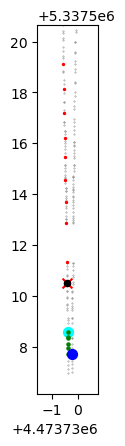

In [5193]:
fig, ax = plt.subplots()

# ax.scatter(p[:,0], p[:,1], c='cyan', s=50)
ax.scatter(pruned_n[:,0], pruned_n[:,1], c='cyan', s=50)
ax.scatter(sub[:, 0], sub[:, 1], c='red', s=2)
#ax.scatter(xyz[:, 0], xyz[:, 1], c='green', s=5)
ax.scatter(cluster[:, 0], cluster[:, 1], c='green', s=5)

ax.scatter(choosen[0], choosen[1], c='red', marker="x", s=50) 
ax.scatter(point[0], point[1], c='blue', s=50)
ax.set_aspect('equal', adjustable='box')


xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=0.1, zorder=0)
ax.set_xlim((xlim[0] - 1, xlim[1] + 1))
ax.set_ylim((ylim[0] - 1, ylim[1] + 1))

ax.scatter(h[0], h[1], c='black', s=20)

In [5194]:
h = backup.head_xyz 

In [5195]:
labels[0]

np.int64(0)

In [5196]:
p, o = pruned_points(cluster)

In [5197]:
p  

[array([4.47372958e+06, 5.33751051e+06, 5.13086309e+02]),
 array([4.47372961e+06, 5.33750859e+06, 5.13099268e+02])]

In [5198]:
cluster   

array([[4.47372958e+06, 5.33751051e+06, 5.13086309e+02],
       [4.47372961e+06, 5.33750859e+06, 5.13099268e+02],
       [4.47372961e+06, 5.33750836e+06, 5.13100634e+02],
       [4.47372961e+06, 5.33750832e+06, 5.13100914e+02],
       [4.47372962e+06, 5.33750811e+06, 5.13102290e+02],
       [4.47372962e+06, 5.33750794e+06, 5.13103373e+02],
       [4.47372962e+06, 5.33750772e+06, 5.13104799e+02]])

In [5199]:
o

1

In [5200]:
p = np.array(p)

In [5201]:
offset  

1

In [5202]:
pruned  

[array([4.47372961e+06, 5.33750859e+06, 5.13099268e+02])]

In [5203]:
pruned_n = np.array(pruned)

In [5204]:
pruned_n

array([[4.47372961e+06, 5.33750859e+06, 5.13099268e+02]])

In [5205]:
cluster  

array([[4.47372958e+06, 5.33751051e+06, 5.13086309e+02],
       [4.47372961e+06, 5.33750859e+06, 5.13099268e+02],
       [4.47372961e+06, 5.33750836e+06, 5.13100634e+02],
       [4.47372961e+06, 5.33750832e+06, 5.13100914e+02],
       [4.47372962e+06, 5.33750811e+06, 5.13102290e+02],
       [4.47372962e+06, 5.33750794e+06, 5.13103373e+02],
       [4.47372962e+06, 5.33750772e+06, 5.13104799e+02]])

In [5206]:
active_line = backup